In [150]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import plotly.express as px

In [151]:
df = pd.read_csv("../west_europe_electricity_data.csv")
df

,date,country,demand,supply,price
0,2010-01-01 00:00:00,Germany,998.434819,860.616813,34.804159
1,2010-01-01 01:00:00,Germany,1113.064624,903.022739,36.977960
2,2010-01-01 02:00:00,Germany,1229.650095,1062.041675,34.734515
3,2010-01-01 03:00:00,Germany,1220.779348,1258.040931,29.111438
4,2010-01-01 04:00:00,Germany,1324.864598,1239.289276,32.071558
...,...,...,...,...,...
587760,2023-05-30 20:00:00,Spain,166.469364,266.629507,28.730414
587761,2023-05-30 21:00:00,Spain,288.222638,269.496763,42.084538
587762,2023-05-30 22:00:00,Spain,304.168404,234.174181,48.966944
587763,2023-05-30 23:00:00,Spain,403.196977,270.147487,54.775206


# Preprocessing data

- Dropping duplicates
- Update pandas DataFrame dtype
- Remove outliers
- Remove noise by calculating moving average
- One-hot-encoding for `country` feature

In [152]:
# Dropping duplicates and reset index
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [153]:
df["date"] = pd.to_datetime(df["date"])

In [154]:
df["price"]=df["price"].fillna(method="ffill")

In [155]:
df = df.groupby('date').agg({'price': 'sum', 'demand': 'sum', "supply":"sum"}).reset_index()

In [156]:
def remove_outliers_zscore(df, series, threshold=4):
    """
    ----------
    df : pandas.DataFrame
        The DataFrame containing the series from which outliers should be removed.
    series : str
        The name of the series (column) in the DataFrame from which outliers should be removed.
    threshold : float, optional
        The Z-score threshold above which a value is considered an outlier, by default 4.
    """
    z_scores = zscore(df[series].to_numpy())

    last_valid = None
    for idx, value in enumerate(df[series]):
        if np.abs(z_scores[idx]) > threshold:
            if last_valid is not None:
                df.loc[idx, series] = last_valid
        else:
            last_valid = value
    return df

df = remove_outliers_zscore(df, "price")

In [157]:
# calculating moving average to remove noise
window = 365
df[f"demand_moving_avg"] = df["demand"].rolling(window=window).mean()
df[f"supply_moving_avg"] = df["supply"].rolling(window=window).mean()
df[f"price_moving_avg"] = df["price"].rolling(window=window).mean()

In [158]:
df.isna().sum().to_dict()

{'date': 0,
 'price': 0,
 'demand': 0,
 'supply': 0,
 'demand_moving_avg': 364,
 'supply_moving_avg': 364,
 'price_moving_avg': 364}

In [159]:
df.dropna(inplace=True)

In [160]:
df.isna().sum().to_dict()

{'date': 0,
 'price': 0,
 'demand': 0,
 'supply': 0,
 'demand_moving_avg': 0,
 'supply_moving_avg': 0,
 'price_moving_avg': 0}

In [161]:
#df = pd.get_dummies(df, columns=["country"])

In [162]:
df.set_index("date", inplace=True)

In [163]:
df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["quarter"] = df.index.quarter
df["month"] = df.index.month
df["dayofyear"] = df.index.dayofyear

In [164]:
df["demand_moving_avg_minus_supply_moving_avg"] = df["demand_moving_avg"] - df["supply_moving_avg"]

<AxesSubplot:>

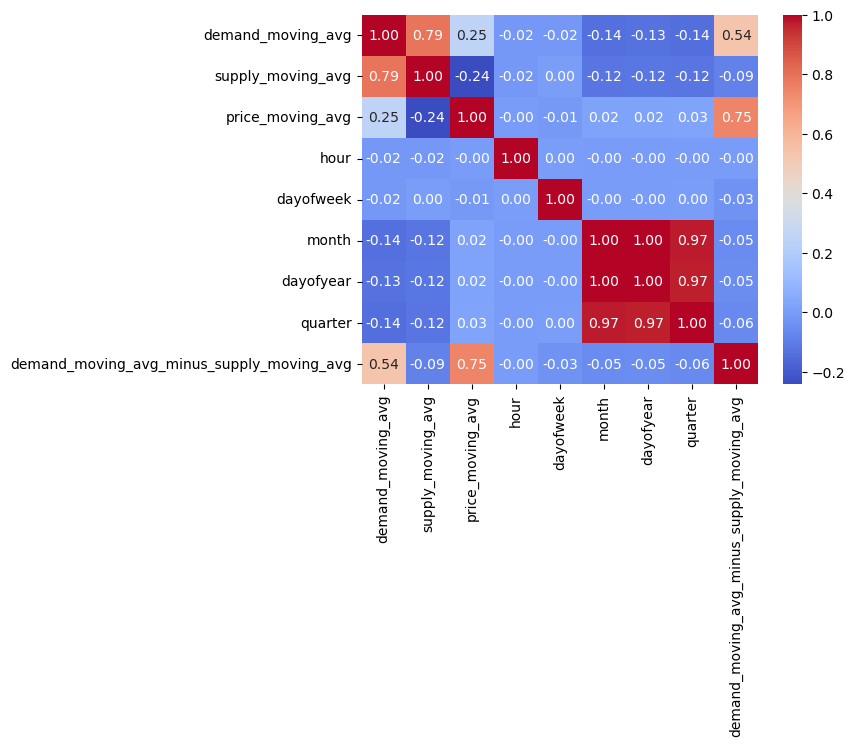

In [165]:
important_features = ["demand_moving_avg", "supply_moving_avg", "price_moving_avg", "hour","dayofweek", "month","dayofyear", "quarter", "demand_moving_avg_minus_supply_moving_avg" ]
correlation_matrix = np.corrcoef(df[important_features].values.T)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', xticklabels=df[important_features].columns, yticklabels=df[important_features].columns)


Interestingly, price is positively correlated with feature `demand_moving_avg_minus_supply_moving_avg`. It means, high demand and less supply leads to increase in price and vice versa.

price is also correlated to `demand_moving_avg` feature.

Splitting data to train-test dataset. We will train our model using 50% of the data and validate it using other 50% of the data.

In [182]:
X_train, X_valid, y_train, y_valid = train_test_split(df[['demand_moving_avg_minus_supply_moving_avg', 'demand_moving_avg', 'supply_moving_avg', 'hour', 'dayofweek', 'quarter', 'month','dayofyear']], df["price_moving_avg"], test_size=0.5, shuffle=False)

In [183]:
reg = xgb.XGBRegressor(n_estimator=1000, early_stopping_rounds=50)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=100)

[23:35:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1685694848790/work/src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[0]	validation_0-rmse:96.28800	validation_1-rmse:116.12720
[99]	validation_0-rmse:0.19697	validation_1-rmse:39.97426


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimator=1000, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [184]:
fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=["importance"])
fi

,importance
demand_moving_avg_minus_supply_moving_avg,0.908856
demand_moving_avg,0.086816
supply_moving_avg,0.002200
hour,0.000319
dayofweek,0.000593
quarter,0.000132
month,0.000444
dayofyear,0.000640


<AxesSubplot:title={'center':'Feature importnace'}>

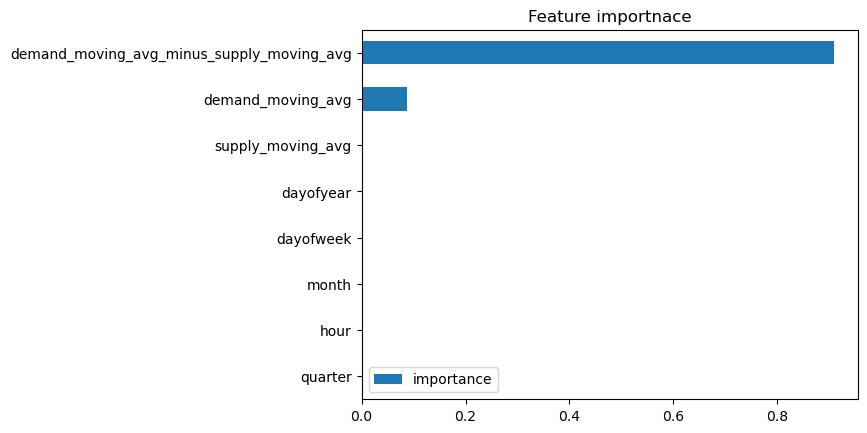

In [185]:
fi.sort_values("importance").plot(kind="barh", title="Feature importnace")

Here, we can observe that demand-supply difference and demand moving average play critical role in predicting price moving average. We also observe the similar behavior from heatmap plot.

In [186]:
predictions = reg.predict(X_valid)

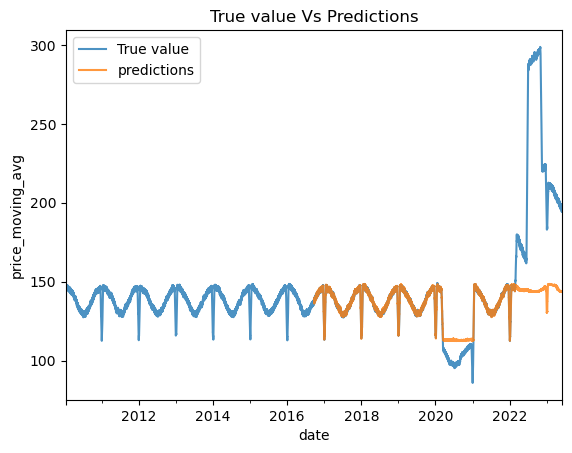

<Figure size 2000x200 with 0 Axes>

In [187]:
X_valid["predictions"] = predictions
df.price_moving_avg.plot(alpha=0.8)
ax = X_valid["predictions"].plot(alpha=0.8)
plt.legend(["True value", "predictions"])
ax.set_ylabel( "price_moving_avg")
ax.set_title("True value Vs Predictions")
plt.figure(figsize=(20,2))
plt.show()

## Observation:

The model typically yields satisfactory results during regular cycles, but it fell short in providing accurate results for the years 2020 and 2022. The year 2020 was marked by the onset of the pandemic, and in 2022, the Russia-Ukraine war took place.